# Task 1

In Moodle you will find the file Potter.zip. Unpack it. It contains 7 txt-files, each containing
the text one of the ”Harry Potter”-books. Load those txt-files into the console of your programming language

In [2]:
from zipfile import ZipFile
import os

# Define the path for the uploaded zip file
zip_file_path = 'Potter.zip'
extracted_folder_path = 'Potter'

# Unzipping the file
with ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Listing the files extracted
extracted_files = os.listdir(extracted_folder_path)
extracted_files


['file1.txt',
 'file2.txt',
 'file3.txt',
 'file4.txt',
 'file5.txt',
 'file6.txt',
 'file7.txt']

# Task 2

To compare the books, we must know, which book it is we are looking at. Each file contains
one particular line for every page in the book:

    Page | page number book name - J.K. Rowling

Use regular expressions to automatically detect the name of the book from the texts.


In [3]:
import re

# Function to read the content of a file and extract the book name using regular expressions
def extract_book_name(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        # Regex pattern to match the book name in the format "Page | page number book name - J.K. Rowling"
        match = re.search(r'Page\s+\|\s+\d+\s+(.+?)\s+-\s+J\.K\.\s+Rowling', content)
        if match:
            return match.group(1)
        else:
            return "Book name not found"

# Extracting book names for each file
book_names = {}
for file_name in extracted_files:
    book_names[file_name] = extract_book_name(os.path.join(extracted_folder_path, file_name))

book_names


{'file1.txt': 'Harry Potter and the Chamber of Secrets',
 'file2.txt': 'Harry Potter and the Goblet of Fire',
 'file3.txt': 'Harry Potter and the Half Blood Prince',
 'file4.txt': 'Harry Potter and the Philosophers Stone',
 'file5.txt': 'Harry Potter and the Order of the Phoenix',
 'file6.txt': 'Harry Potter and the Deathly Hallows',
 'file7.txt': 'Harry Potter and the Prisoner of Azkaban'}

# Task 3

The texts in the the txt-files are not ”clean” yet. To analyze them properly, we need to do
additional preprocessing steps.
* Remove the page indicator from the texts. That is, remove all lines that have the form mentioned in task 2
* Trim the start of the document until the first chapter starts.
* Remove the headers of all chapters. These are written in CAPS (all letters are capitalized). Detect this using regular expressions.
* Replace all line breaks (”\n”) with a whitespace (” ”).

The result should be a list of 7 large stings, one for each book.

In [4]:
# Function to clean the text of each file according to the specified preprocessing steps
def preprocess_text(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        content = file.read()
        
        # Remove page indicators
        content = re.sub(r'Page\s+\|\s+\d+\s+.+?\s+-\s+J\.K\.\s+Rowling', '', content)
        
        # Trim the start of the document until the first chapter starts (assuming the first chapter starts after the first capitalized header)
        first_chapter_start = re.search(r'([A-Z\s]{20,})', content)  # Looking for a long all-caps header to indicate the start
        if first_chapter_start:
            content = content[first_chapter_start.start():]
        
        # Remove all chapter headers
        content = re.sub(r'\n([A-Z\s]{20,})\n', ' ', content)  # Assuming chapter headers are in caps and at least 20 characters long
        
        # Replace all line breaks with a whitespace
        content = content.replace('\n', ' ')
        
        return content.strip()

# Preprocessing text for each file and collecting the results in a list
processed_texts = [preprocess_text(os.path.join(extracted_folder_path, file_name)) for file_name in extracted_files]

# Verifying the type of the result for the first processed text to ensure it's a large string
type(processed_texts[0]), len(processed_texts)


(str, 7)

# Task 4

Apply elementary preprocessing steps. The result should be a list of lists. Each inner list
represents a book as a list of words.

In [7]:
import string

# Function to apply elementary preprocessing steps: tokenize the text into words, remove punctuation, numbers, special characters, and convert to lowercase
def elementary_preprocessing(text):
    # Remove punctuation and numbers, then convert to lowercase
    cleaned_text = re.sub(r'[' + string.punctuation + string.digits + ']', ' ', text).lower()
    # Tokenize the text into words
    tokens = cleaned_text.split()
    return tokens

# Applying elementary preprocessing to each book's text
preprocessed_books = [elementary_preprocessing(text) for text in processed_texts]

# Verifying the type of the result for the first book to ensure it's a list of words
type(preprocessed_books[0]), len(preprocessed_books[0][:10]), preprocessed_books[0][:10]


(list,
 10,
 ['n', 'g', 'not', 'for', 'the', 'first', 'time', 'an', 'argument', 'had'])

# Task 5

Calculate the tfidf for your corpus. Return the words with the highest tfidf for each of the 7
books. Does the result give you an idea of what the books are about? If not, why?


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Since TfidfVectorizer expects raw documents, we need to convert our list of words back into strings for each book
books_as_strings = [' '.join(book) for book in preprocessed_books]

# Creating the TF-IDF model
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(books_as_strings)

# Getting the feature names (words) that correspond to the columns in the TF-IDF matrix
feature_names = vectorizer.get_feature_names_out()

# Function to get the highest TF-IDF scores and corresponding words for each book
def get_top_tfidf_words(tfidf_matrix, feature_names, top_n=10):
    top_words = []
    for row in tfidf_matrix:
        # Sorting the TF-IDF values in descending order and getting the top n
        sorted_indices = np.argsort(row.toarray()).flatten()[::-1][:top_n]
        top_features = [(feature_names[index], row[0, index]) for index in sorted_indices]
        top_words.append(top_features)
    return top_words

# Getting the top 10 TF-IDF words for each book
top_tfidf_words_per_book = get_top_tfidf_words(tfidf_matrix, feature_names)

top_tfidf_words_per_book


[[('the', 0.5760437117925488),
  ('and', 0.30632565535790757),
  ('to', 0.28612835940024334),
  ('harry', 0.2328299395119627),
  ('of', 0.2305857955166667),
  ('he', 0.21529756454871252),
  ('was', 0.17756789362779807),
  ('said', 0.17083546164191),
  ('it', 0.16901209464573197),
  ('his', 0.16396277065631593)],
 [('the', 0.5768170389243479),
  ('and', 0.30834886623600843),
  ('to', 0.29684838716644807),
  ('he', 0.24651833360396344),
  ('of', 0.24466341762500207),
  ('harry', 0.19761038229201583),
  ('was', 0.1694156594118033),
  ('said', 0.1631089450833347),
  ('his', 0.1596464352559402),
  ('it', 0.14653836233794665)],
 [('the', 0.5388606974195205),
  ('to', 0.30581667067666607),
  ('and', 0.2928062372818196),
  ('he', 0.25491871146166223),
  ('of', 0.24348096781784118),
  ('harry', 0.20101834454015544),
  ('you', 0.18314687009668498),
  ('said', 0.17449707646604531),
  ('was', 0.17006495080406464),
  ('his', 0.15977098152462568)],
 [('the', 0.5637156731518904),
  ('and', 0.30090753

#### 
The words with the highest TF-IDF scores for each of the 7 "Harry Potter" books have been identified. However, the result primarily includes common English words such as "the", "and", "to", "he", along with the name "Harry". These results, while reflective of the text's focus on the main character, do not provide a deep insight into the distinct themes or plots of each book.

The dominance of common words and the name "Harry" in the highest TF-IDF scores might be due to these words being both frequent and somewhat distinctive across different books but not sufficiently filtered to highlight unique thematic elements. Additionally, the TF-IDF model emphasizes words unique to a document in a corpus but might not always filter out common words effectively if they appear with varying frequency across documents.

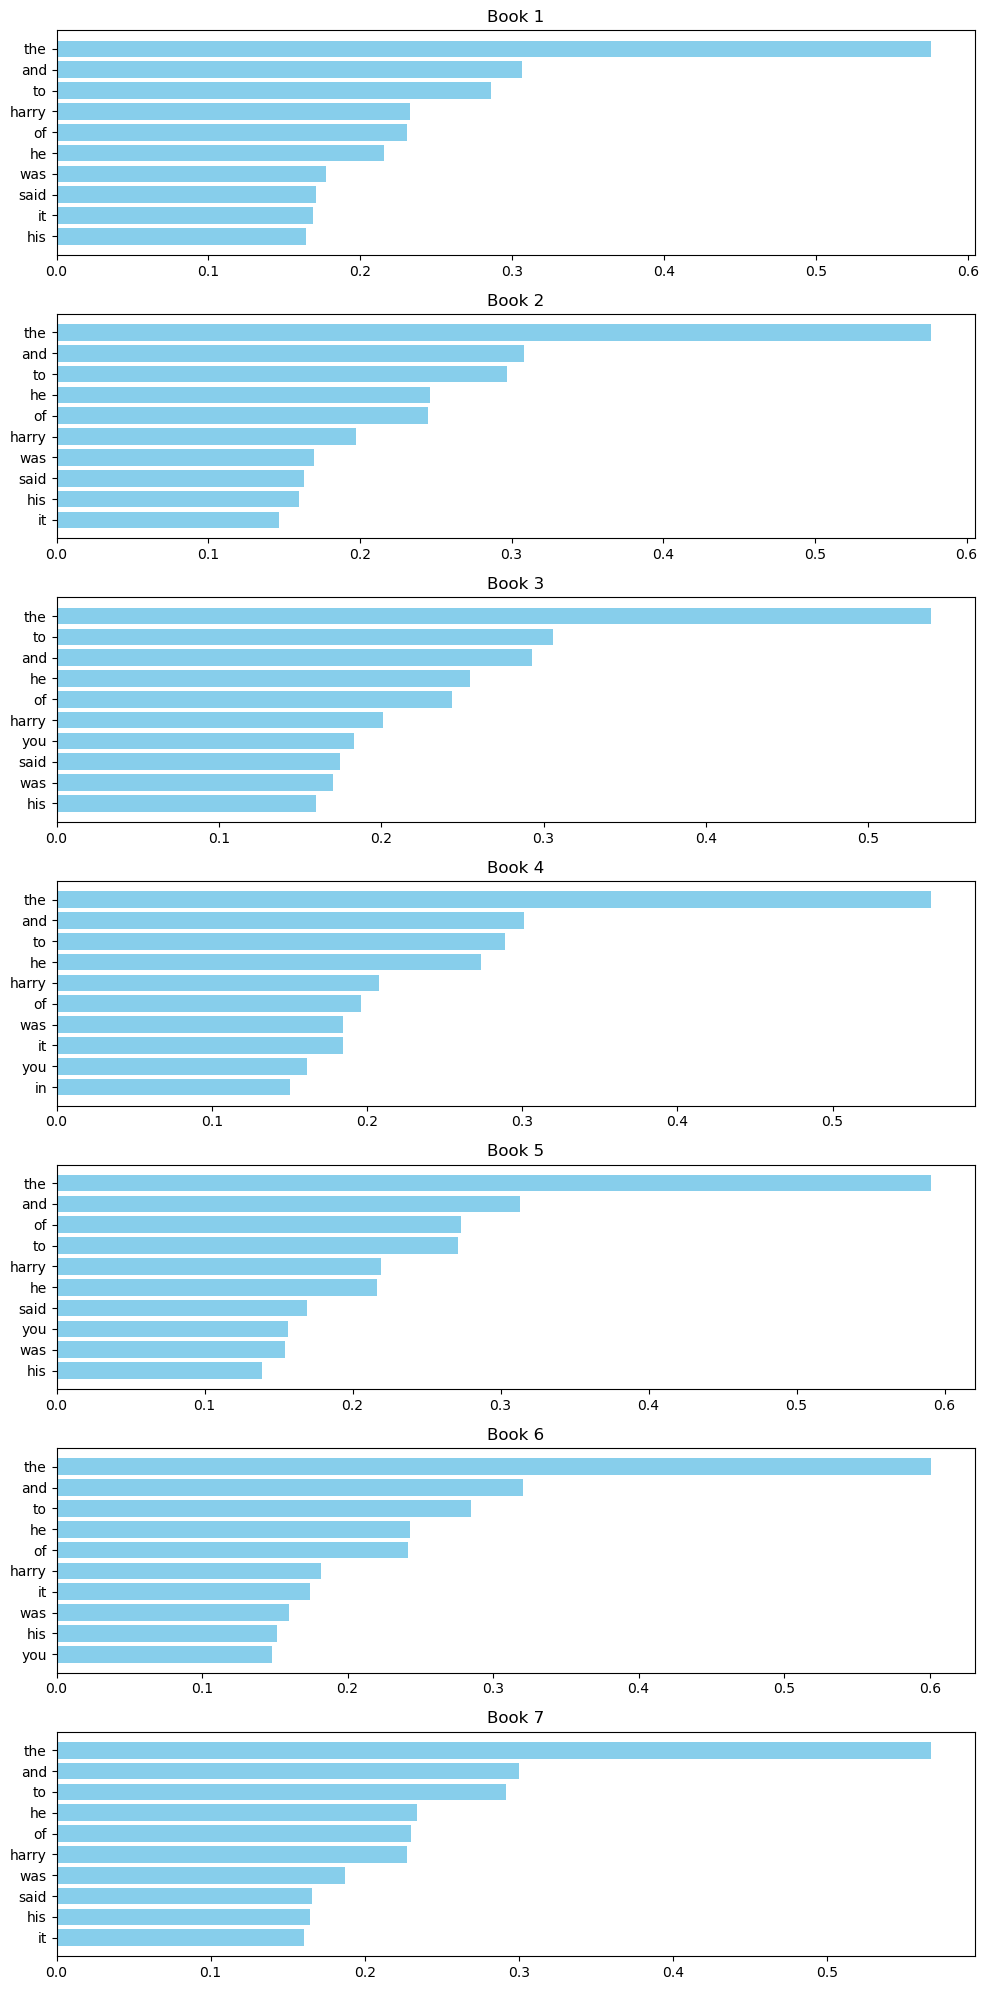

In [9]:
import matplotlib.pyplot as plt

# Function to plot the top TF-IDF words for each book
def plot_top_tfidf_words(top_words_per_book):
    fig, axes = plt.subplots(7, 1, figsize=(10, 20))

    for i, book_words in enumerate(top_words_per_book):
        words, scores = zip(*book_words)
        axes[i].barh(words, scores, color='skyblue')
        axes[i].set_title(f'Book {i+1}')
        axes[i].invert_yaxis()  # To display the highest score at the top

    plt.tight_layout()
    plt.show()

# Plotting the top TF-IDF words for each of the 7 books
plot_top_tfidf_words(top_tfidf_words_per_book)


### Thank you